## Synthetic brainset 

The goal of this script is to generate some synthetic data and generate from it a `brainset` object for training neurofoundation models. 

### RiaB data generation 

Use `RatInABox` to generate 2 hours of data from 200 synthetic neurons. These neurons have smooth random spatial tuning curves. 

In [61]:
import numpy as np 
import tqdm
import ratinabox 
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent 
from ratinabox.Neurons import RandomSpatialNeurons

# Params 
T = 0.2*60*60  # total time to simulate (s)
DT = 0.01    # simulation time step (s)
N = 100      # number of neurons
MAX_FR = 5  # maximum firing rate (Hz)


env = Environment() # Create environment
agent = Agent( # Create agent
    env,
    params={
        'dt':DT
        }
    )
neurons = RandomSpatialNeurons( # Create neuron population
    agent,
    params={
        'n':N,
        'max_fr':MAX_FR,}
    )

# Simulate for 2 hours 
for _ in tqdm.tqdm(range(int(T/DT))):
    agent.update()
    neurons.update()

100%|██████████| 72000/72000 [00:23<00:00, 3025.68it/s]


## Visualize the data

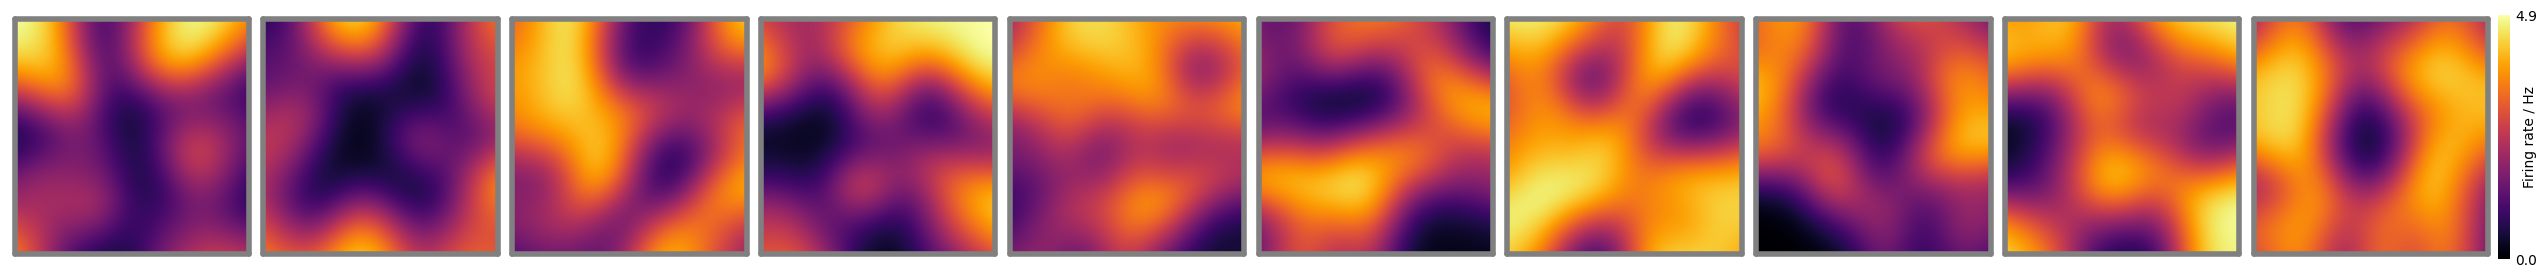

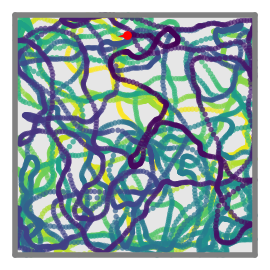

In [62]:
# Plot the receptive fields (10 of them) 
neurons.plot_rate_map(chosen_neurons="10");

# Plot the trajectory (first 5 minutes)
agent.plot_trajectory(t_max=5*60, color='changing');

Now we'll extract the data, and save it in `temporaldata` format. 

In [68]:
spikes = neurons.get_history_arrays()['spikes']  # spike times (s)
pos = agent.get_history_arrays()['pos']      # position (x,y) (cm)
t = neurons.get_history_arrays()['t']   # time vector (s)

spike_times = []
spike_unit_ids = []
for neuron_id in range(spikes.shape[1]):
    neuron_spike_times = t[spikes[:, neuron_id]]
    spike_times.extend(neuron_spike_times)
    spike_unit_ids.extend([neuron_id]*len(neuron_spike_times))
spike_times = np.array(spike_times)
spike_unit_ids = np.array(spike_unit_ids)



In [72]:
from temporaldata import IrregularTimeSeries, Interval, RegularTimeSeries

# Create IrregularTimeSeries object
domain = Interval(start = 0, end = agent.t)
neural_data = IrregularTimeSeries(
    timestamps=spike_times,
    unit_index=spike_unit_ids,
    domain=domain,
    )

cursor = RegularTimeSeries(
    pos=pos,
    sampling_rate=1/DT,
    domain=domain,
    )



In [65]:
neural_data

IrregularTimeSeries(
  timestamps=[185617],
  unit_index=[185617]
)

In [ ]:
#@title Define plotting utils

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, RangeTool
import numpy as np

from bokeh.models import Button
from bokeh.models.callbacks import CustomJS
from bokeh.layouts import row, column

output_notebook()

def plot_spikes(spikes, add_range_tool=False, x_range=None, width=800, height=400):
    """
    Plots an IrregularTimeSeries object defined by spikes.timestamps and spikes.unit_index.

    Parameters:
    spikes: An object containing 'timestamps' and 'unit_index' attributes.
    """
    if x_range is None:
        if add_range_tool:
            x_range = (spikes.timestamps[0] * 1e3, spikes.timestamps[0] * 1e3 + 20_000)
        else:
            x_range = (spikes.timestamps[0] * 1e3, spikes.timestamps[-1] * 1e3)

    # Create a figure
    p = figure(x_axis_label='Time', y_axis_label='Unit Index', width=width, height=height, x_axis_type="datetime", x_range=x_range, title="Spikes")

    # Prepare data for plotting
    x_values = spikes.timestamps * 1e3
    y_values = spikes.unit_index

    # Create a ColumnDataSource
    source = ColumnDataSource(data=dict(x=x_values, y=y_values))

    # Add scatter points to the plot
    p.scatter('x', 'y', source=source, size=5, color="navy", alpha=0.5, marker="dash", angle=np.pi/2)

    if add_range_tool:
        select = figure(height=height//5, width=width, tools="",
                        toolbar_location=None, background_fill_color="#efefef", x_axis_type="datetime",
                        title="Average Population Activity")
        select.xaxis.visible = False
        # select.yaxis.visible = False

        range_tool = RangeTool(x_range=p.x_range)
        range_tool.overlay.fill_color = "navy"
        range_tool.overlay.fill_alpha = 0.2

        spike_times_int = spikes.timestamps.astype(int)
        population_activity =np.bincount(spike_times_int-spike_times_int[0])
        source = ColumnDataSource(data=dict(x=(np.arange(len(population_activity)) + spike_times_int[0])* 1e3, y=population_activity))

        select.line('x', 'y', source=source)
        select.ygrid.grid_line_color = None
        select.add_tools(range_tool)
        p = column(select, p)

    return p

def plot_time_series(data, field, index=None, x_range=None, add_range_tool=False, y_axis_label=None, width=800, height=200, include_control_panel=False, shade_area_list=[]):
    # Create a figure
    if x_range is None:
        if add_range_tool:
            x_range = (data.timestamps[0] * 1e3, data.timestamps[0] * 1e3 + 20_000)
        else:
            x_range = (data.timestamps[0] * 1e3, data.timestamps[-1] * 1e3)

    if y_axis_label is None:
        y_axis_label = field

    p = figure(x_axis_label='Time', y_axis_label=y_axis_label, width=width, height=height, x_axis_type="datetime", x_range=x_range)


    domain_start = data.domain.start * 1e3
    domain_end = data.domain.end * 1e3
    # Prepare data for plotting
    x_values = data.timestamps * 1e3
    y_values = getattr(data, field)

    x_values = np.concatenate([x_values, domain_start, domain_end])
    y_values = np.concatenate([y_values, np.nan * np.ones((len(data.domain), * y_values.shape[1:])), np.nan * np.ones((len(data.domain), *y_values.shape[1:]))])

    # sort x_values and reorder y_values
    sort_indices = np.argsort(x_values)
    x_values = x_values[sort_indices]
    y_values = y_values[sort_indices]

    if y_values.ndim == 1:
        # Add a line to the plot
        source = ColumnDataSource(data=dict(x=x_values, y=y_values))
    elif y_values.ndim == 2:
        assert index is not None, "Index must be provided for 2D data"
        source = ColumnDataSource(data=dict(x=x_values, y=y_values[:, index]))
    else:
        raise ValueError(f"Field {field} has {y_values.ndim} dimensions, expected 1 or 2")

    p.line(x='x', y='y', source=source, line_width=2, color="green")
    x_range = p.x_range

    colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'brown', 'pink', 'gray', 'black']
    for i, shade_area in enumerate(shade_area_list):
        start = shade_area.start * 1e3
        end = shade_area.end * 1e3
        rect_x = (start + end)/2
        rect_width = end - start
        rect_y = np.ones_like(start) * (y_values.min() + y_values.max())/2
        rect_height = np.ones_like(start) * (y_values.max() - y_values.min())
        p.rect(x=rect_x, y=rect_y, width=rect_width, height=rect_height, fill_color=colors[i], fill_alpha=0.4)
        # legend_items.append((f"Shade Area {i+1}", [p.renderers[-1]]))  # Add the rectangle to the legend items

    # p.legend.items = legend_items
    # p.legend.location = "top_left"  # Set the legend location
    # p.legend.click_policy = "hide"  # Allow clicking to hide the legend items

    if add_range_tool:
        select = figure(height=height//5, width=width, y_range=p.y_range, tools="",
                        toolbar_location=None, background_fill_color="#efefef", x_axis_type="datetime",)
        select.xaxis.visible = False
        select.yaxis.visible = False

        range_tool = RangeTool(x_range=p.x_range)
        range_tool.overlay.fill_color = "navy"
        range_tool.overlay.fill_alpha = 0.2

        select.line('x', 'y', source=source)
        select.ygrid.grid_line_color = None
        select.add_tools(range_tool)
        p = column(select, p)

        if include_control_panel:
            # Add a button to control the range tool
            play_button = Button(label="Play", button_type="success")
            pause_button = Button(label="Pause", button_type="warning")
            speed_buttons = [Button(label=f"{2**i}x", button_type="primary") for i in range(5)]

            # Create a shared ColumnDataSource to store the interval ID
            shared_data = ColumnDataSource(data=dict(interval_id=[None], step_size=[1000]))

            # Update the CustomJS to use the shared data source
            play_button.js_on_click(CustomJS(args=dict(range_tool=range_tool, x_values=x_values, shared_data=shared_data), code="""
                // Clear previous interval if it exists
                if (shared_data.data.interval_id[0]) {
                    clearInterval(shared_data.data.interval_id[0]);
                }

                // Create new interval and store it in the shared data
                let new_interval = setInterval(() => {
                    if (range_tool.x_range.end < x_values[x_values.length - 1]) {
                        range_tool.x_range.start += shared_data.data.step_size[0] / 10;
                        range_tool.x_range.end += shared_data.data.step_size[0] / 10;
                    } else {
                        clearInterval(shared_data.data.interval_id[0]);
                        shared_data.data.interval_id[0] = null;
                        shared_data.change.emit();
                    }
                }, 100);

                shared_data.data.interval_id[0] = new_interval;
                shared_data.change.emit();
            """));

            pause_button.js_on_click(CustomJS(args=dict(shared_data=shared_data), code="""
                if (shared_data.data.interval_id[0]) {
                    clearInterval(shared_data.data.interval_id[0]);
                    shared_data.data.interval_id[0] = null;
                    shared_data.change.emit();
                }
            """));

            for button in speed_buttons:
                button.js_on_click(CustomJS(args=dict(button=button, shared_data=shared_data), code="""
                    shared_data.data.step_size[0] = 1000 * parseInt(button.label.replace('x', ''));
                    shared_data.change.emit();
                """));

            # Add the buttons to the layout
            button_layout = row(play_button, pause_button, *speed_buttons)
            return p, x_range, button_layout

    return p



Loading BokehJS ...

In [67]:
p = plot_spikes(neural_data, add_range_tool=True)
show(p)

AttributeError: unexpected attribute 'show' to Column, possible attributes are align, aspect_ratio, children, context_menu, css_classes, css_variables, disabled, elements, flow_mode, height, height_policy, html_attributes, html_id, js_event_callbacks, js_property_callbacks, margin, max_height, max_width, min_height, min_width, name, resizable, sizing_mode, spacing, styles, stylesheets, subscribed_events, syncable, tags, visible, width or width_policy